# aSPEM Experiment : analysis




In [3]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from scipy import stats

In [4]:
%matplotlib inline

In [5]:
def risk(p):
    return (2*p-1)**3

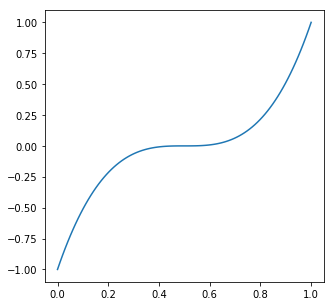

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
p = np.linspace(0, 1, 100, endpoint=True)
ax.plot(p, risk(p) );

In [5]:
def invrisk(bet):
    return (np.sign(bet) * np.abs(bet)**(1/3) +1)/2

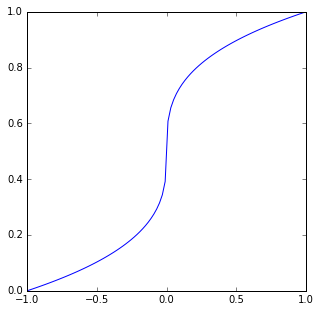

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
bet = np.linspace(-1, 1, 100, endpoint=True)
ax.plot(bet, invrisk(bet) );

In [6]:
fig_width = 15

from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [7]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)
    #print(a)

In [8]:
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']:
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [9]:
param = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK']:
        a = 'parametre/param_Fit_%s.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

# Variation de h

## Bet

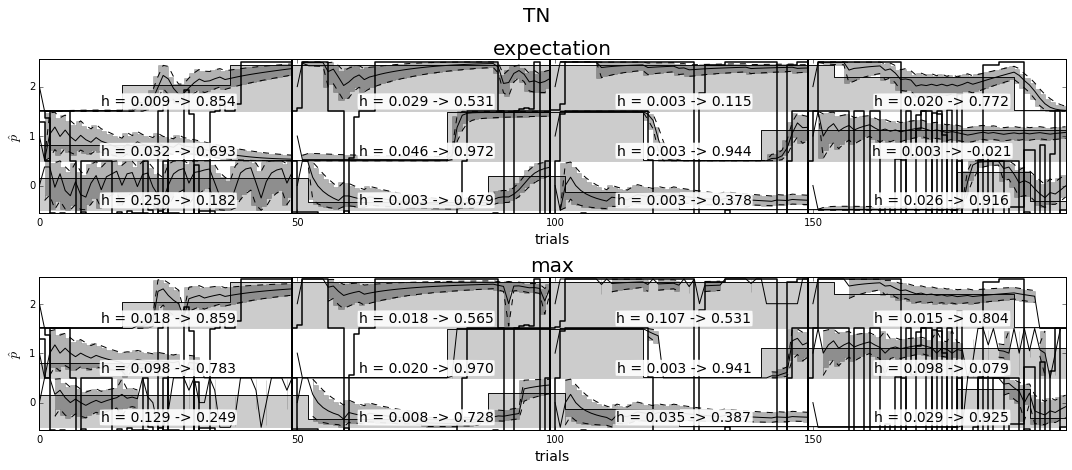

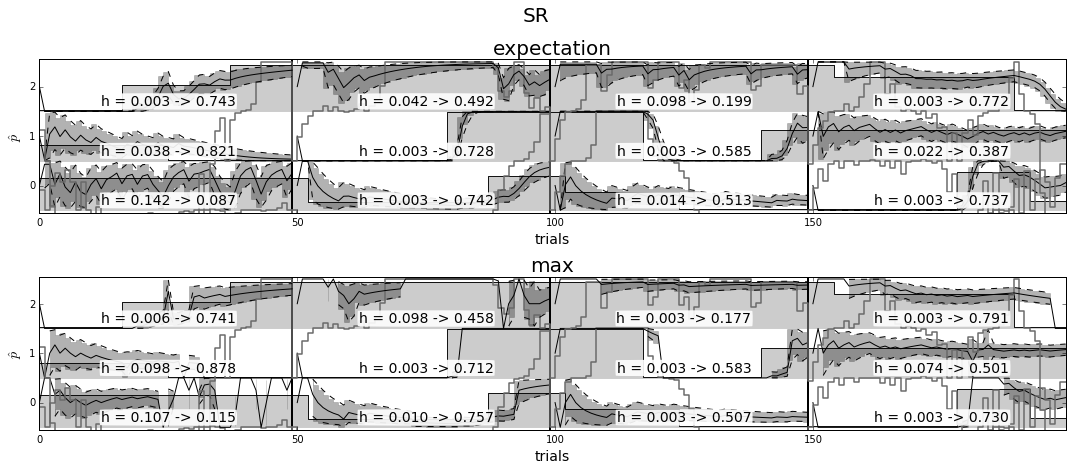

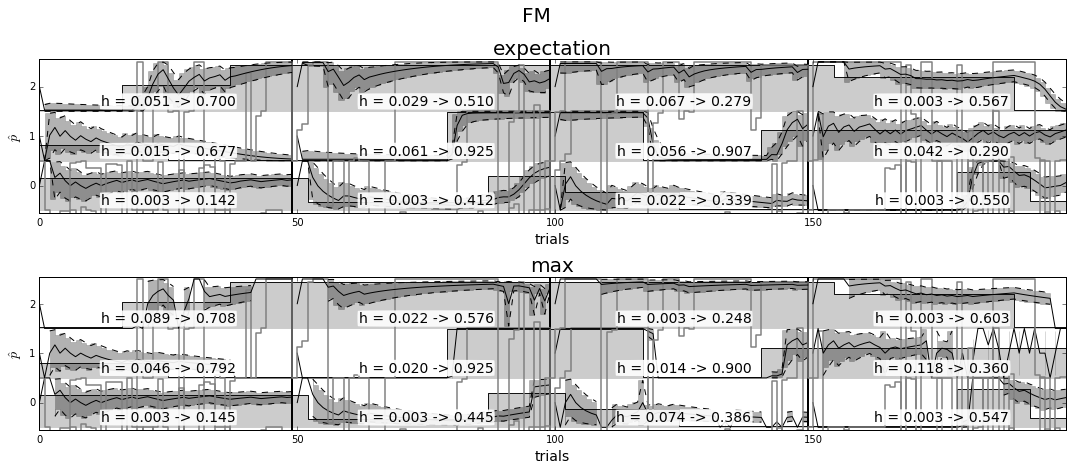

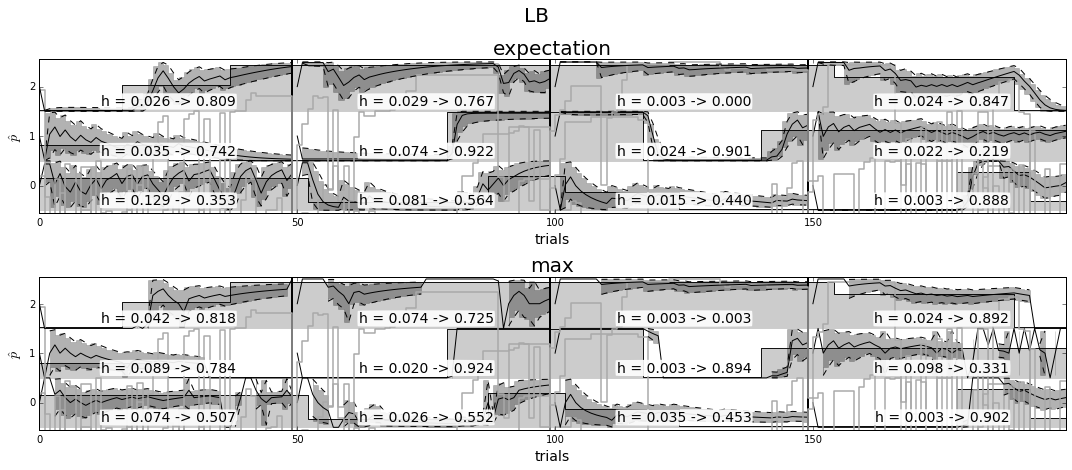

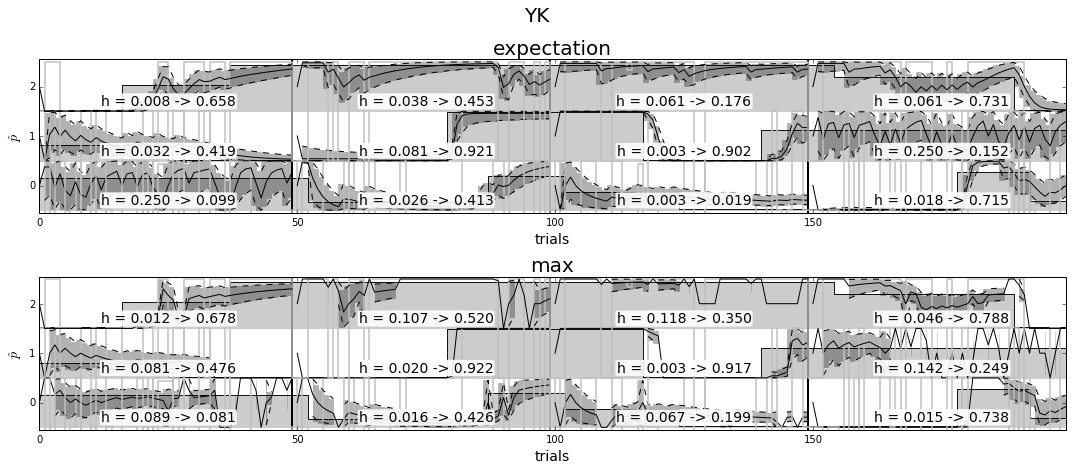

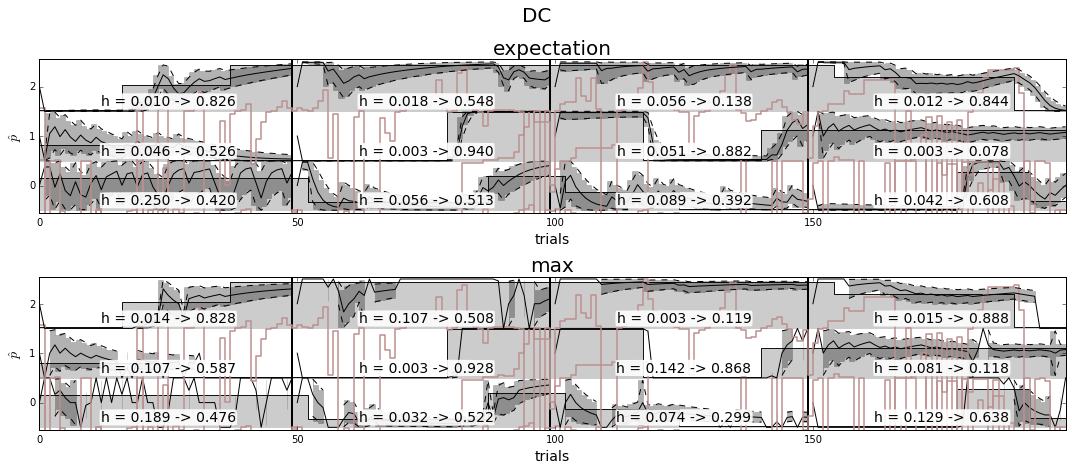

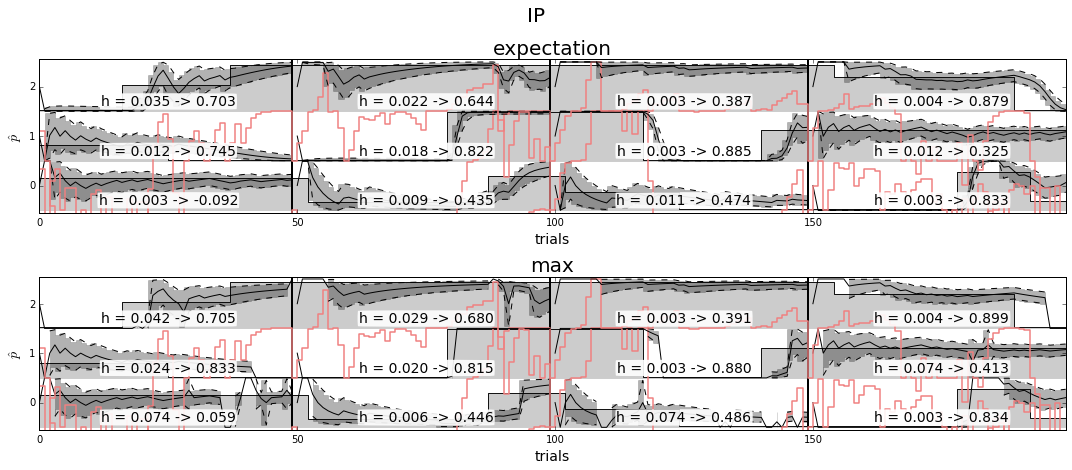

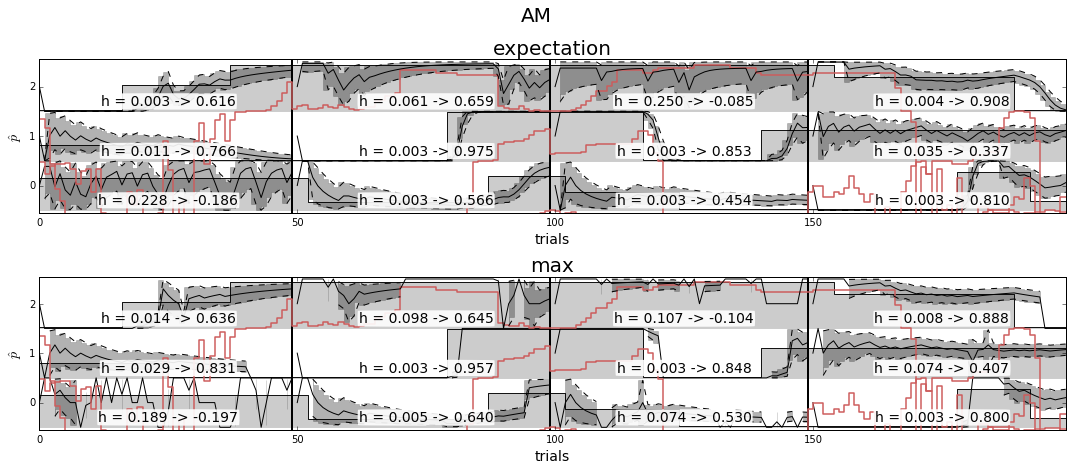

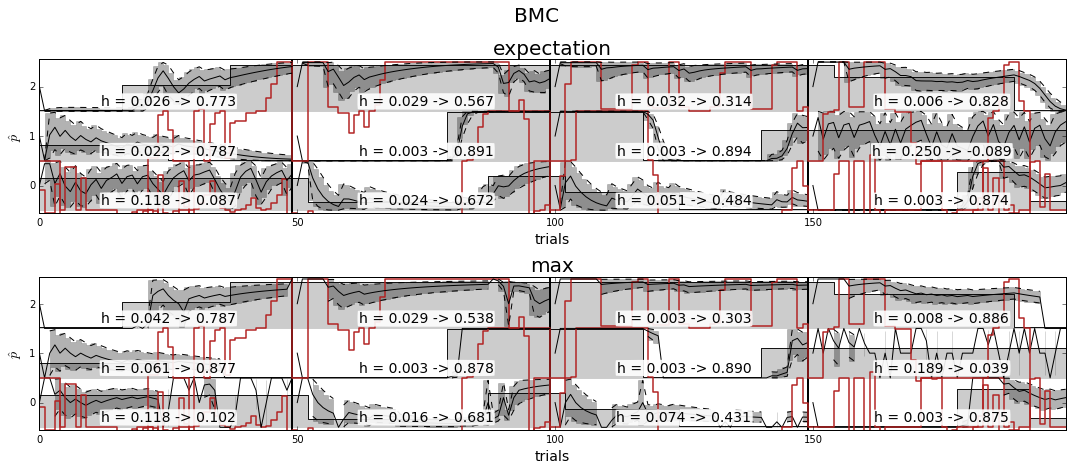

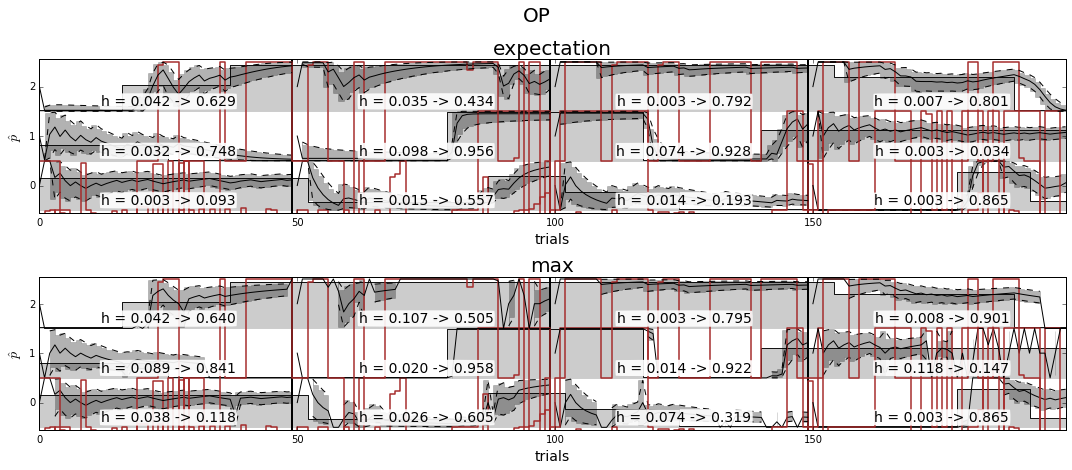

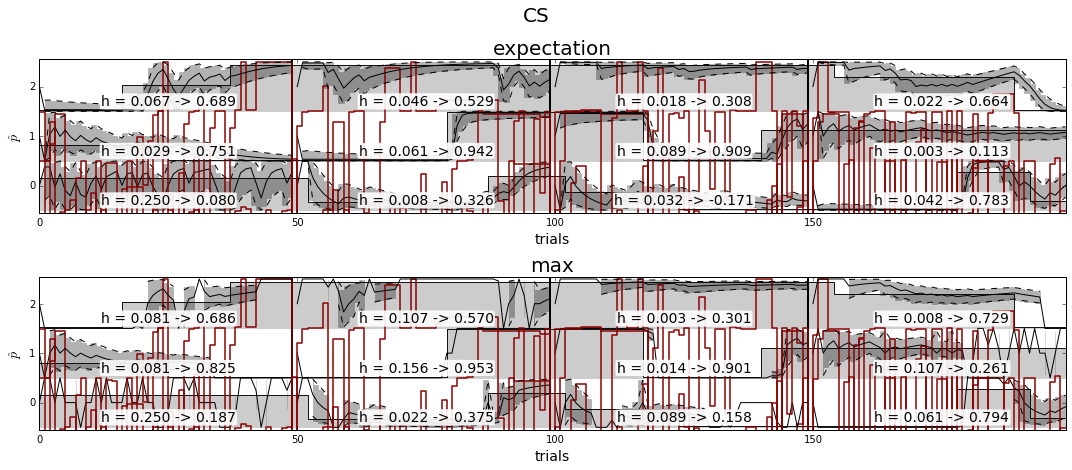

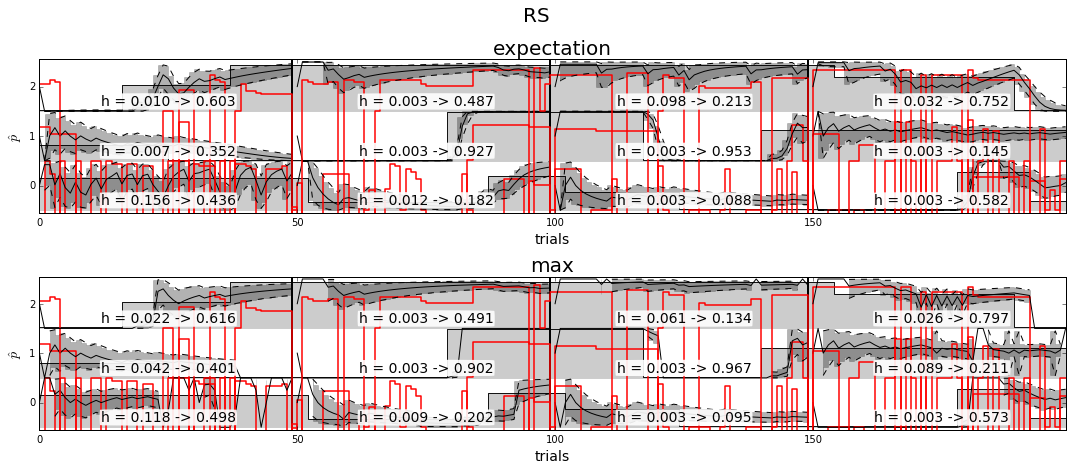

In [10]:
h_bet_e = []
h_bet_m = []
coco_bet = []
#'darkgrey', 'lightgrey',
for x, color in enumerate(['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']):
    fig, axs = plt.subplots(2, 1, figsize=(fig_width, 2*fig_width/(1.6180*3)))
    
    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    p = exp[x]['p']
    tau = N_trials/5.
    h = 1./tau 
    hs = h*np.logspace(-1., 1., 50)
    
    h_bet_e.append([])
    h_bet_m.append([])
    coco_bet.append([])
    
    stick = np.zeros_like(p)
    stick[:, :, 0] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    stick[:, :, 1] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    stick[:, :, 2] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    
    plt.suptitle('%s'%(exp[x]['observer']), fontsize=20, y=1.05)
    for s, mode in enumerate(['expectation', 'max']):
        coco_bet[x].append([])
        
        axs[s].step(range(N_trials), p[:, :, 1]+stick[:, :, 1], lw=1, c='k', alpha=.9)
        axs[s].axis('tight')
        axs[s].set_yticks(np.arange(N_blocks)+.5)
        axs[s].set_yticklabels(np.arange(N_blocks) )
        axs[s].set_ylabel(r'$\^p$', fontsize=14)
        axs[s].bar(49, 3.1, bottom=-0.05, color='k', width=0, linewidth=2)
        axs[s].bar(99, 3.1, bottom=-0.05, color='k', width=0, linewidth=2)
        axs[s].bar(149, 3.1, bottom=-0.05, color='k', width=0, linewidth=2)

        results = (2*exp[x]['results']-1)**3 #(exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]

        
        for block in range(N_blocks):
            axs[s].step(range(N_trials), block + results[:, block],  color=color, lw=1.5)
            axs[s].fill_between(range(N_trials), block + np.zeros_like(p[:, block, 1]), block + p[:, block, 1],
                                lw=.5, alpha=.2, facecolor='black', step='pre')
            coef = np.ndarray(50)
            
            #----------------------------------------------------
            # Pour chaque pause !
            #----------------------------------------------------
            liste = [0,50,100,150,200]
            for a in range(len(liste)-1) :
                for H in range(len(hs)):
                    p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=hs[H], p0=.5)
                    p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
                    coef[H] = np.corrcoef(results[liste[a]:liste[a+1], block], p_hat)[0][1]
                
                tutu = coef.argmax()
                p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=hs[tutu], p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
                p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
                
                for i_trial in range(50):#N_trials):
                    p_low[i_trial], p_sup[i_trial] = stats.beta.ppf([.05, .95], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])
                axs[s].plot(np.arange(liste[a], liste[a+1]), block + p_hat, c='k',  lw=1)
                axs[s].plot(np.arange(liste[a], liste[a+1]), block + p_sup, 'k--', lw=1)
                axs[s].plot(np.arange(liste[a], liste[a+1]), block + p_low, 'k--', lw=1)
                axs[s].fill_between(np.arange(liste[a], liste[a+1]), block + p_sup, block + p_low, lw=.5, alpha=.3, facecolor='k', step='pre')
                axs[s].text(liste[a]+(liste[a+1]-liste[a])/2, block+0.2, 'h = %0.3f -> %0.3f'%(hs[tutu], np.corrcoef(results[liste[a]:liste[a+1], block], p_hat)[0][1]),
                            color='k',bbox={'fc':'white', 'alpha':0.9,'lw':0, 'pad':0.1, 'boxstyle':'round4'},
                            va='center', ha='center', fontsize=14)
                if mode=='expectation' :
                    h_bet_e[x].append(hs[tutu])
                elif mode=='max' :
                    h_bet_m[x].append(hs[tutu])
            
                coco_bet[x][s].append(coef[tutu])
            
        axs[s].set_ylim(-.05, N_blocks + .05)
        axs[s].set_xlabel('trials', fontsize=14)
        axs[s].set_title('%s'%(mode), fontsize=20)
        fig.tight_layout()
        
    plt.show()

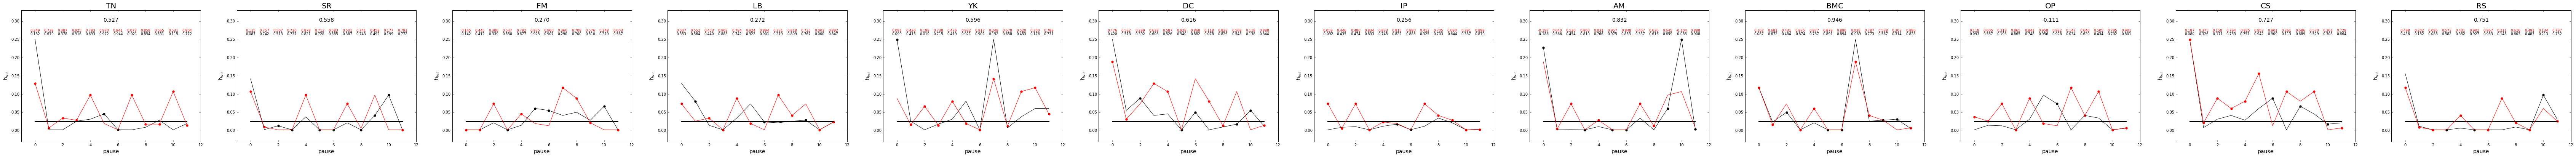

In [11]:
fig, axs = plt.subplots(1, len(exp), figsize=((fig_width*len(exp))/1.5, (fig_width/1.5)/(1.6180)))

for x in range(len(exp)):
    axs[x].set_title('%s'%(exp[x]['observer']), fontsize=20)
    axs[x].plot(range(len(h_bet_m[0])), np.ones(len(h_bet_m[0]))*0.025, color='k', linewidth=2)
    axs[x].plot(h_bet_e[x], c='k')
    axs[x].plot(h_bet_m[x], c='r')
    for lala in range(len(coco_bet[x][0])) :
        axs[x].text(lala, 0.27, '%0.3f'%(coco_bet[x][0][lala]),color='k', ha='center', va='top', fontsize=9)
        axs[x].text(lala, 0.27, '%0.3f'%(coco_bet[x][1][lala]),color='r', ha='center', va='bottom', fontsize=9)

        if coco_bet[x][0][lala] > coco_bet[x][1][lala] :
            axs[x].scatter(lala, h_bet_e[x][lala], c='k', lw=0, s=40)
        else :
            axs[x].scatter(lala, h_bet_m[x][lala], c='r', lw=0, s=40)
    
    axs[x].set_xlabel('pause', fontsize=14)
    axs[x].set_ylabel('h$_{bet}$', fontsize=14)
    axs[x].axis([-1, 12, -0.03, 0.33])
    axs[x].text(5.5, 0.31, '%0.3f'%(np.corrcoef(h_bet_e[x], h_bet_m[x])[0][1]), color='k', ha='center', va='top', fontsize=14)
plt.show()

In [12]:
new_h_bet_e = []
new_h_bet_m = []
new_coco_bet_e =[]
new_coco_bet_m =[]
for x in range(len(h_bet_e[0])):
    new_h_bet_e.append([])
    new_h_bet_m.append([])
    new_coco_bet_e.append([])
    new_coco_bet_m.append([])
    for a in range(len(h_bet_e)):
        new_h_bet_e[x].append(h_bet_e[a][x])
        new_h_bet_m[x].append(h_bet_m[a][x])
        
        new_coco_bet_e[x].append(coco_bet[a][0][x])
        new_coco_bet_m[x].append(coco_bet[a][1][x])

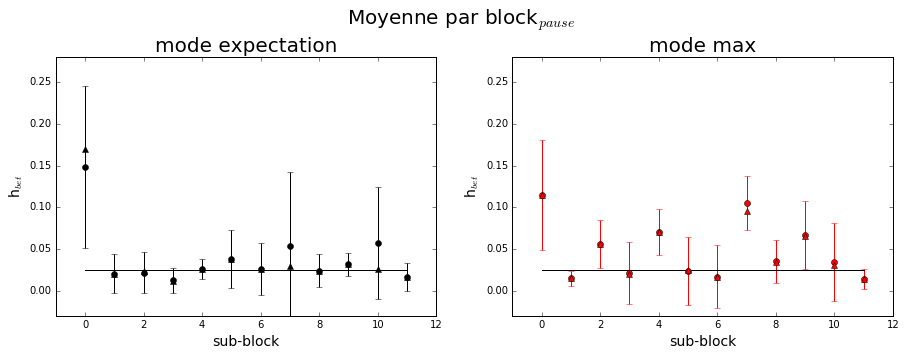

In [13]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par block$_{pause}$', fontsize=20, y=1.05)

axs[0].plot(range(len(h_bet_m[0])), np.ones(len(h_bet_m[0]))*0.025, color='k', linewidth=1)
axs[1].plot(range(len(h_bet_m[0])), np.ones(len(h_bet_m[0]))*0.025, color='k', linewidth=1)
for x in range(len(h_bet_e[0])):
    axs[0].errorbar(x, np.mean(new_h_bet_e[x]), yerr=np.std(new_h_bet_e[x]),color='k', fmt='o')
    axs[1].errorbar(x, np.mean(new_h_bet_m[x]), yerr=np.std(new_h_bet_m[x]),color='r', fmt='o')
    
    axs[0].errorbar(x, np.average(new_h_bet_e[x], weights=new_coco_bet_e[x]),color='k', fmt='^')
    axs[1].errorbar(x, np.average(new_h_bet_m[x], weights=new_coco_bet_m[x]),color='r', fmt='^')

axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('sub-block', fontsize=14)
axs[0].set_ylabel('h$_{bet}$', fontsize=14)
axs[0].axis([-1, 12, -0.03, 0.28])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('sub-block', fontsize=14)
axs[1].set_ylabel('h$_{bet}$', fontsize=14)
axs[1].axis([-1, 12, -0.03, 0.28])

plt.show()

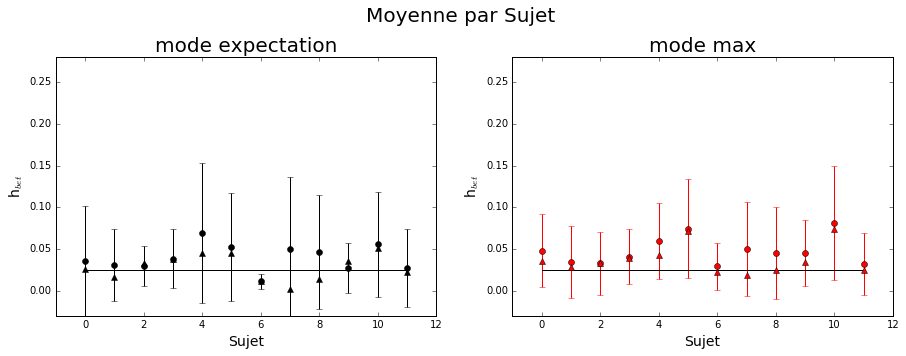

In [14]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par Sujet', fontsize=20, y=1.05)

axs[0].plot(range(len(h_bet_m)), np.ones(len(h_bet_m))*0.025, color='k', linewidth=1)
axs[1].plot(range(len(h_bet_m)), np.ones(len(h_bet_m))*0.025, color='k', linewidth=1)

for x in range(len(h_bet_e)):
    axs[0].errorbar(x, np.mean(h_bet_e[x]), yerr=np.std(h_bet_e[x]),color='k', fmt='o')
    axs[1].errorbar(x, np.mean(h_bet_m[x]), yerr=np.std(h_bet_m[x]),color='r', fmt='o')
    
    axs[0].errorbar(x, np.average(h_bet_e[x], weights=coco_bet[x][0]),color='k', fmt='^')
    axs[1].errorbar(x, np.average(h_bet_m[x], weights=coco_bet[x][1]),color='r', fmt='^')

axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('Sujet', fontsize=14)
axs[0].set_ylabel('h$_{bet}$', fontsize=14)
axs[0].axis([-1, 12, -0.03, 0.28])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('Sujet', fontsize=14)
axs[1].set_ylabel('h$_{bet}$', fontsize=14)
axs[1].axis([-1, 12, -0.03, 0.28])

plt.show()

## V$_a$

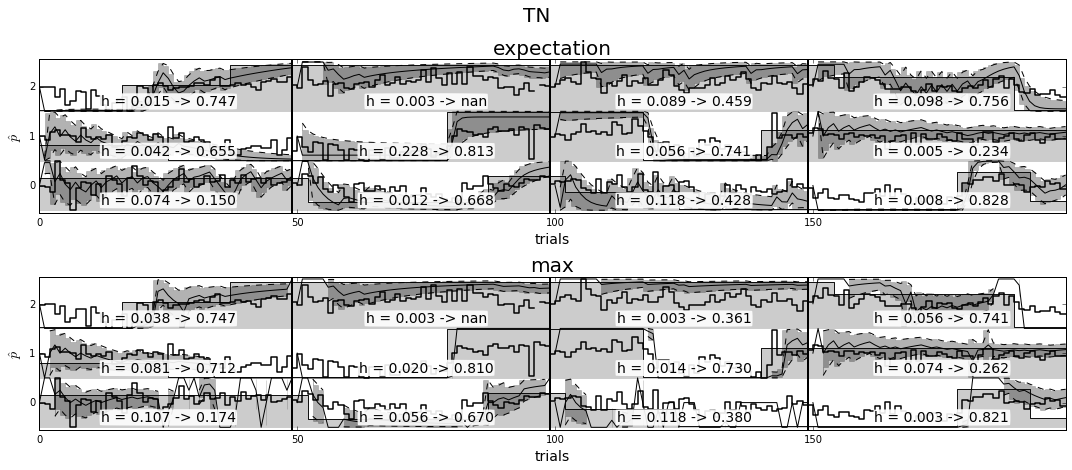

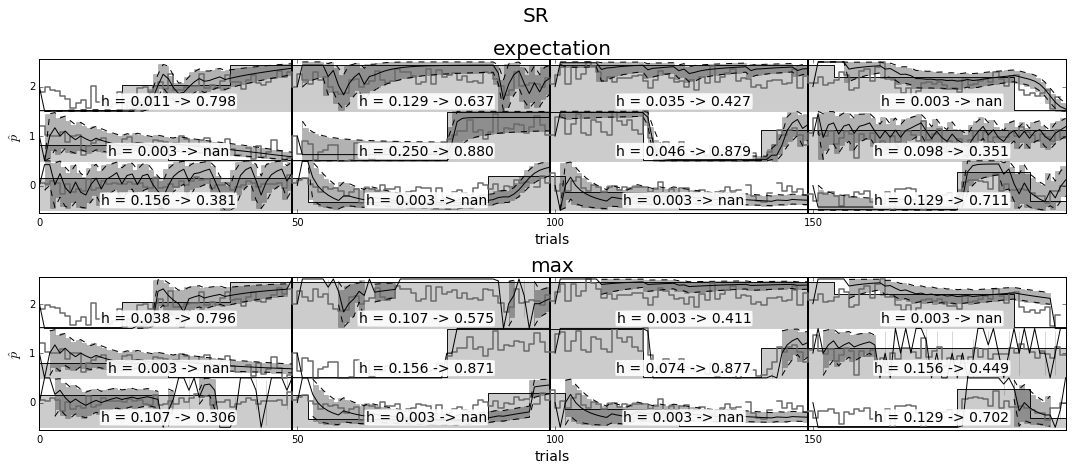

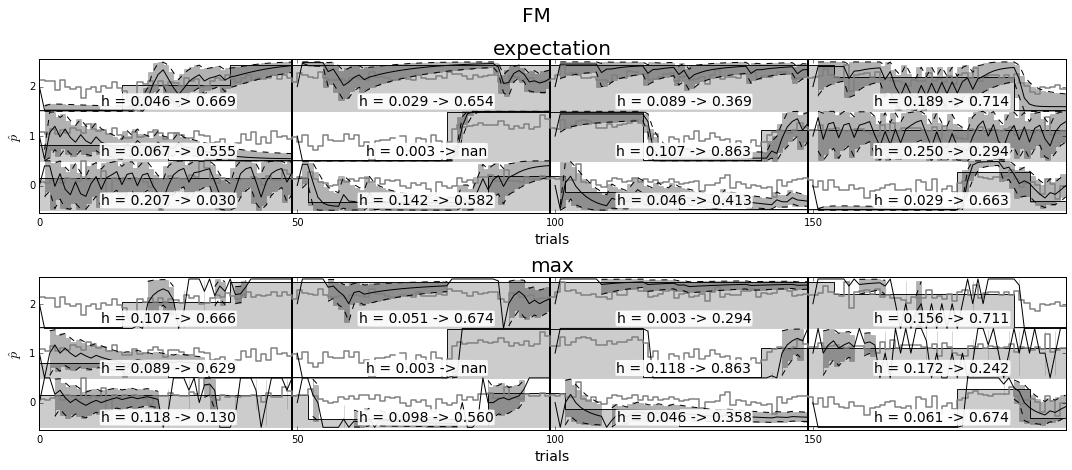

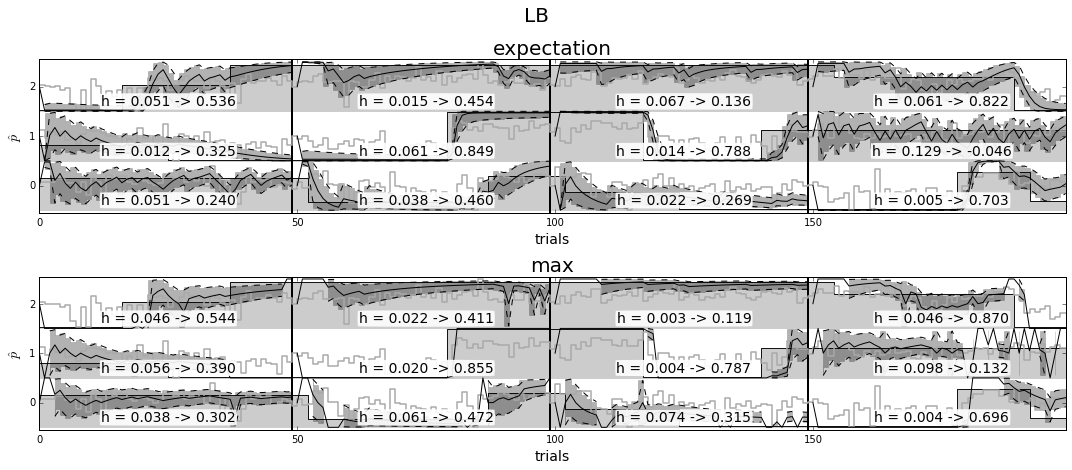

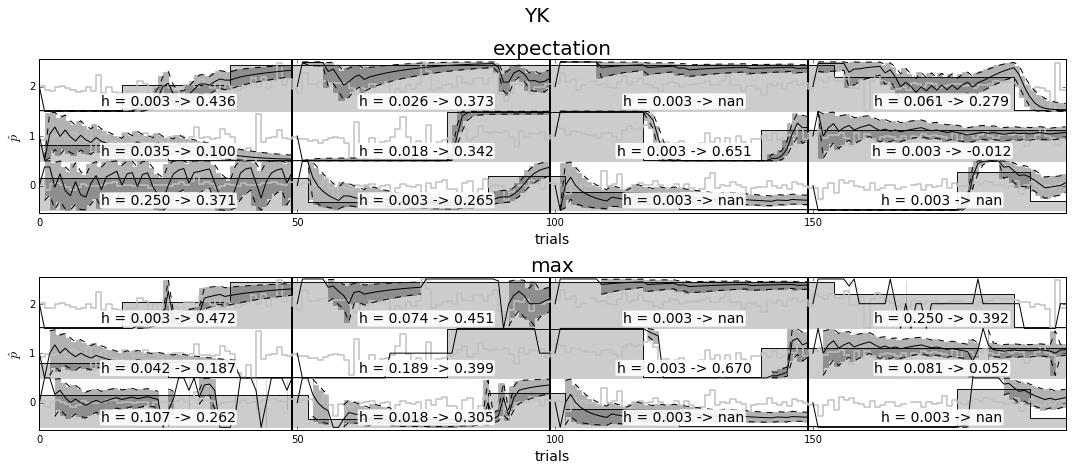

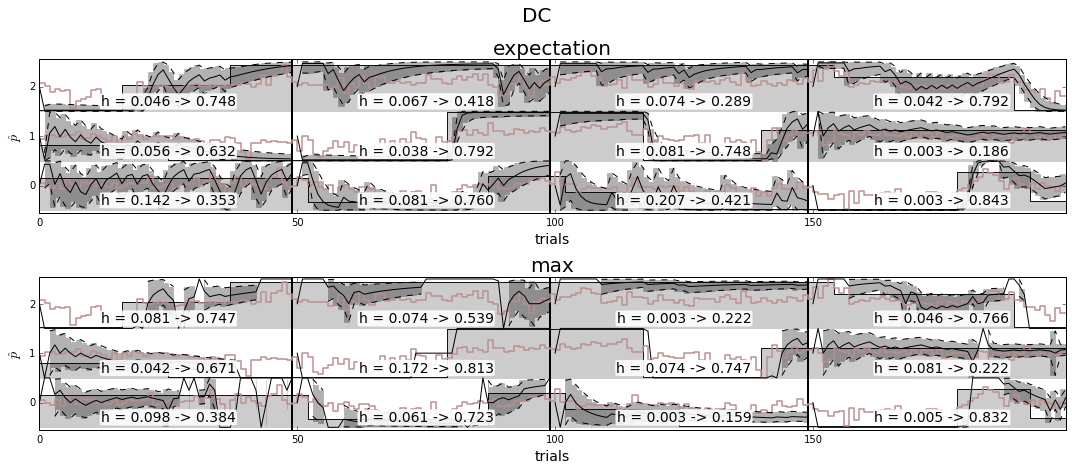

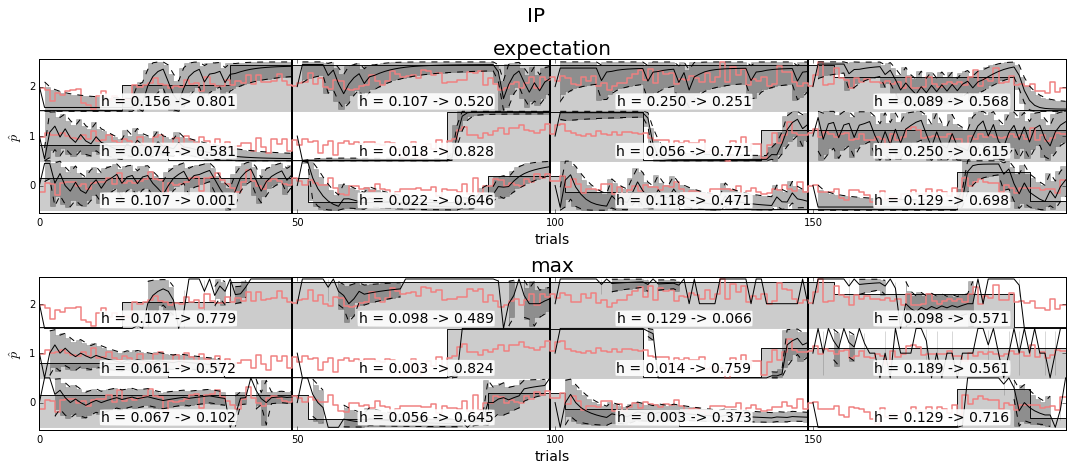

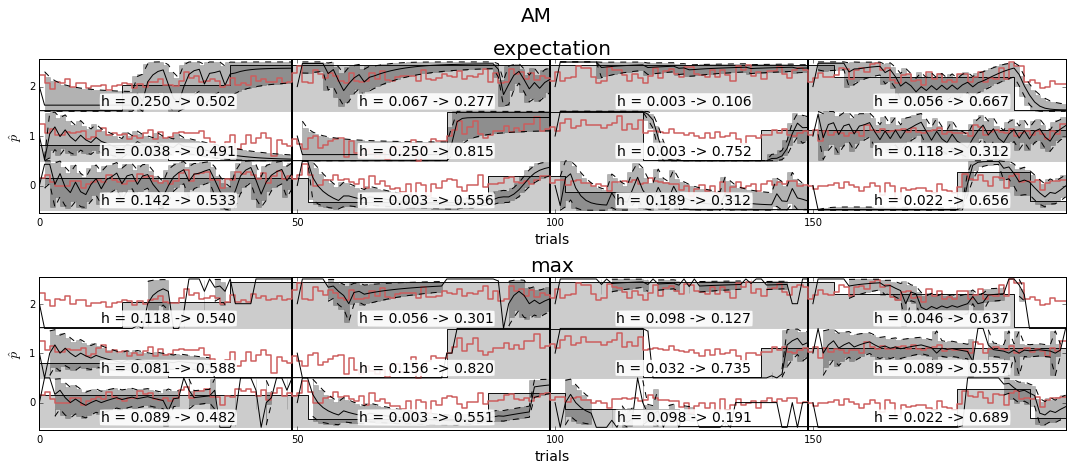

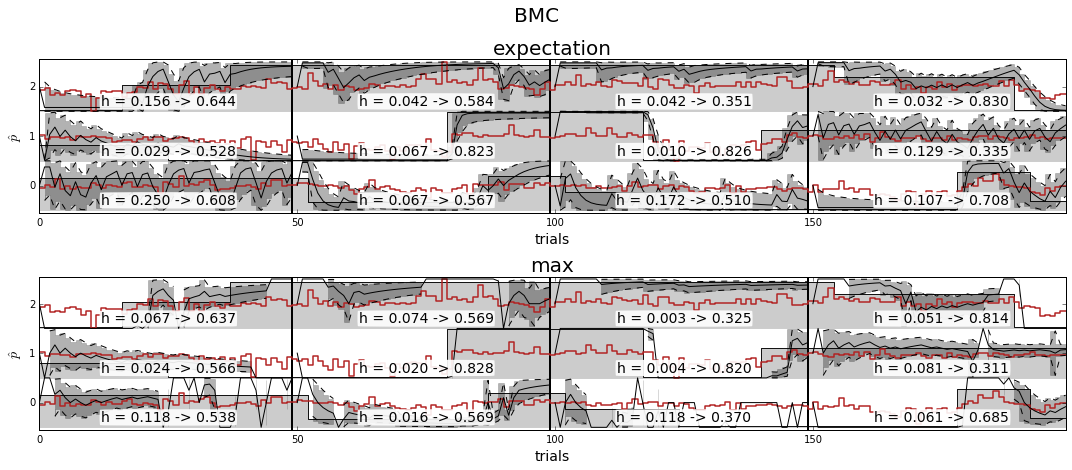

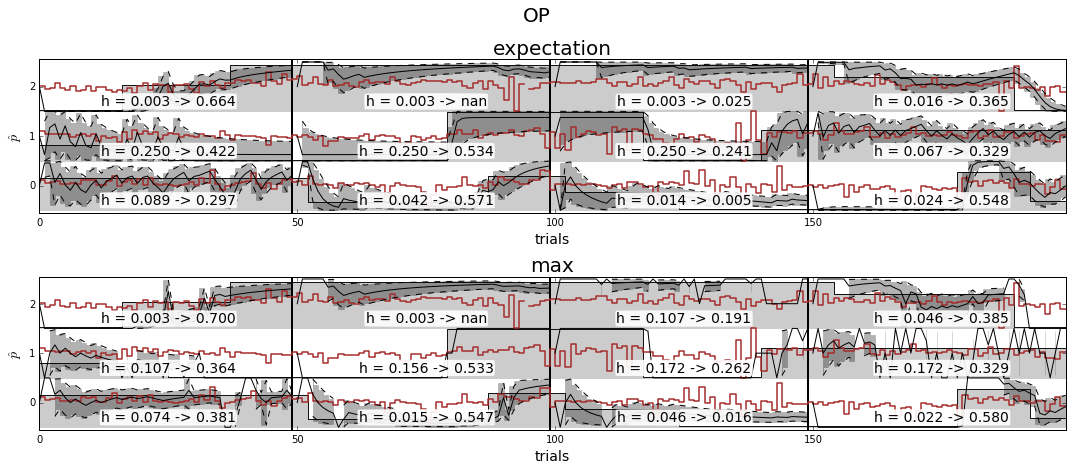

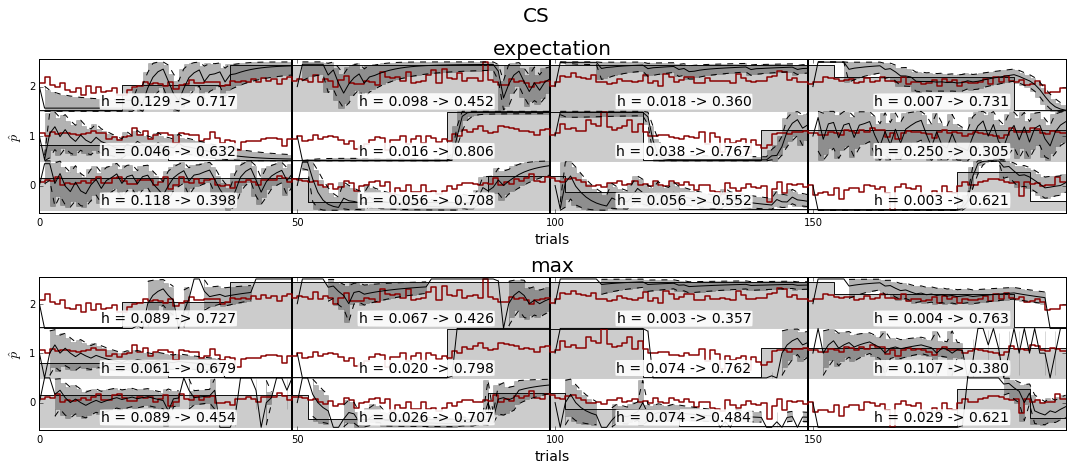

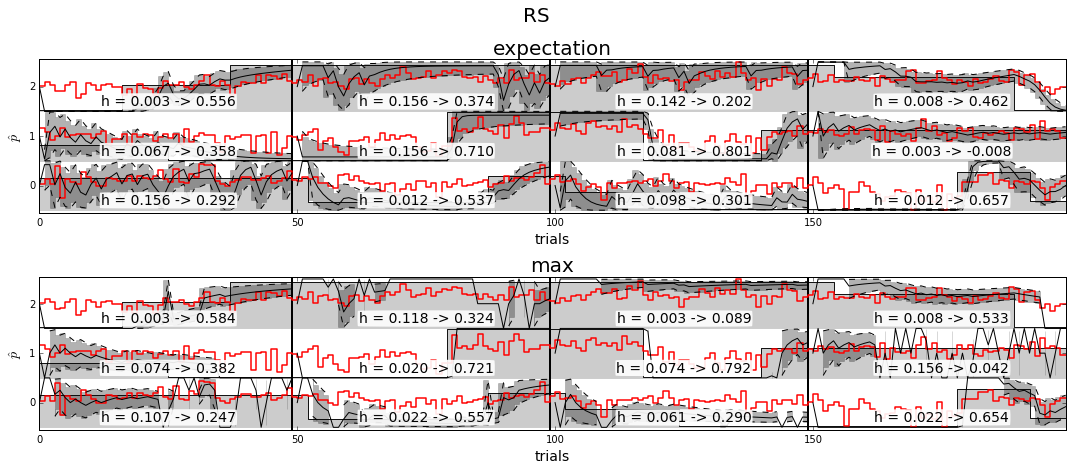

In [15]:
h_va_e = []
h_va_m = []
coco_va = []
# 'darkgrey', 'lightgrey',
for x, color in enumerate(['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']):
    fig, axs = plt.subplots(2, 1, figsize=(fig_width, 2*fig_width/(1.6180*3)))
    
    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    p = exp[x]['p']
    tau = N_trials/5.
    h = 1./tau 
    hs = h*np.logspace(-1., 1., 50)
    
    h_va_e.append([])
    h_va_m.append([])
    coco_va.append([])
    
    stick = np.zeros_like(p)
    stick[:, :, 0] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    stick[:, :, 1] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    stick[:, :, 2] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    
    plt.suptitle('%s'%(exp[x]['observer']), fontsize=20, y=1.05)
    for s, mode in enumerate(['expectation', 'max']):
        coco_va[x].append([])
        
        axs[s].step(range(N_trials), p[:, :, 1]+stick[:, :, 1], lw=1, c='k', alpha=.9)
        axs[s].axis('tight')
        axs[s].set_yticks(np.arange(N_blocks)+.5)
        axs[s].set_yticklabels(np.arange(N_blocks) )
        axs[s].set_ylabel(r'$\^p$', fontsize=14)
        axs[s].bar(49, 3.1, bottom=-0.05, color='k', width=0, linewidth=2)
        axs[s].bar(99, 3.1, bottom=-0.05, color='k', width=0, linewidth=2)
        axs[s].bar(149, 3.1, bottom=-0.05, color='k', width=0, linewidth=2)

        v_anti = param[x]['v_anti']
        
        for block in range(N_blocks):
            axs[s].step(range(N_trials), block+((np.array(v_anti[block])-np.nanmin(v_anti))/(np.nanmax(v_anti)-np.nanmin(v_anti))),
                        color=color, lw=1.5)
            axs[s].fill_between(range(N_trials), block + np.zeros_like(p[:, block, 1]), block + p[:, block, 1],
                                lw=.5, alpha=.2, facecolor='black', step='pre')
            coef = np.ndarray(50)
            
            #----------------------------------------------------
            # Pour chaque pause !
            #----------------------------------------------------
            liste = [0,50,100,150,200]
            for a in range(len(liste)-1) :
                for H in range(len(hs)):
                    p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=hs[H], p0=.5)
                    p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
                    coef[H] = np.corrcoef(v_anti[block][liste[a]:liste[a+1]], p_hat)[0][1]
                
                tutu = coef.argmax()
                p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=hs[tutu], p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
                p_low, p_sup = np.zeros_like(p_hat), np.zeros_like(p_hat)
                
                for i_trial in range(50):#N_trials):
                    p_low[i_trial], p_sup[i_trial] = stats.beta.ppf([.05, .95], a=p_hat[i_trial]*r_hat[i_trial], b=(1-p_hat[i_trial])*r_hat[i_trial])
                axs[s].plot(np.arange(liste[a], liste[a+1]), block + p_hat, c='k',  lw=1)
                axs[s].plot(np.arange(liste[a], liste[a+1]), block + p_sup, 'k--', lw=1)
                axs[s].plot(np.arange(liste[a], liste[a+1]), block + p_low, 'k--', lw=1)
                axs[s].fill_between(np.arange(liste[a], liste[a+1]), block + p_sup, block + p_low, lw=.5, alpha=.3, facecolor='k', step='pre')
                axs[s].text(liste[a]+(liste[a+1]-liste[a])/2, block+0.2, 'h = %0.3f -> %0.3f'%(hs[tutu], np.corrcoef(v_anti[block][liste[a]:liste[a+1]], p_hat)[0][1]),
                            color='k',bbox={'fc':'white', 'alpha':0.9,'lw':0, 'pad':0.1, 'boxstyle':'round4'},
                            va='center', ha='center', fontsize=14)
                if mode=='expectation' :
                    h_va_e[x].append(hs[tutu])
                elif mode=='max' :
                    h_va_m[x].append(hs[tutu])
            
                coco_va[x][s].append(coef[tutu])
            
        
        axs[s].set_ylim(-.05, N_blocks + .05)
        axs[s].set_xlabel('trials', fontsize=14)
        axs[s].set_title('%s'%(mode), fontsize=20)
        fig.tight_layout()
        
    plt.show()

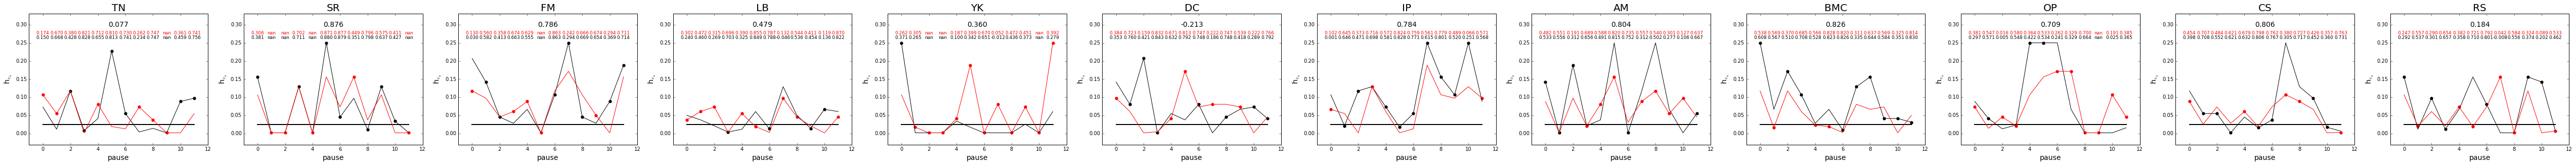

In [16]:
fig, axs = plt.subplots(1, len(exp), figsize=((fig_width*(len(exp)/2)), (fig_width)/(1.6180*2)))

for x in range(len(exp)):
    axs[x].set_title('%s'%(exp[x]['observer']), fontsize=20)
    axs[x].plot(range(len(h_va_m[0])), np.ones(len(h_va_m[0]))*0.025, color='k', linewidth=2)
    axs[x].plot(h_va_e[x], c='k')
    axs[x].plot(h_va_m[x], c='r')
    for lala in range(len(coco_bet[x][0])) :
        axs[x].text(lala, 0.27, '%0.3f'%(coco_va[x][0][lala]),color='k', ha='center', va='top', fontsize=9)
        axs[x].text(lala, 0.27, '%0.3f'%(coco_va[x][1][lala]),color='r', ha='center', va='bottom', fontsize=9)

        if coco_va[x][0][lala] > coco_va[x][1][lala] :
            axs[x].scatter(lala, h_va_e[x][lala], c='k', lw=0, s=40)
        else :
            axs[x].scatter(lala, h_va_m[x][lala], c='r', lw=0, s=40)
    
    axs[x].set_xlabel('pause', fontsize=14)
    axs[x].set_ylabel('h$_{v_a}$', fontsize=14)
    axs[x].axis([-1, 12, -0.03, 0.33])
    axs[x].text(5.5, 0.31, '%0.3f'%(np.corrcoef(h_va_e[x], h_va_m[x])[0][1]), color='k', ha='center', va='top', fontsize=14)
plt.show()

In [17]:
new_h_va_e = []
new_h_va_m = []
new_coco_va_e =[]
new_coco_va_m =[]
for x in range(len(h_va_e[0])):
    new_h_va_e.append([])
    new_h_va_m.append([])
    new_coco_va_e.append([])
    new_coco_va_m.append([])
    for a in range(len(h_va_e)):
        new_h_va_e[x].append(h_va_e[a][x])
        new_h_va_m[x].append(h_va_m[a][x])
        
        new_coco_va_e[x].append(coco_va[a][0][x])
        new_coco_va_m[x].append(coco_va[a][1][x])

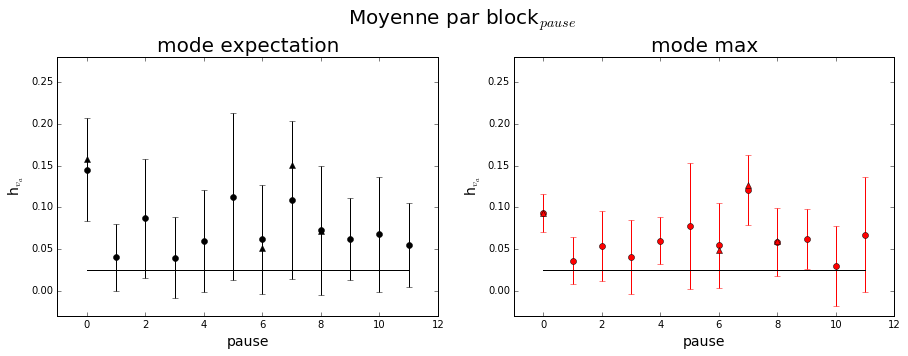

In [18]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par block$_{pause}$', fontsize=20, y=1.05)

axs[0].plot(range(len(h_va_m[0])), np.ones(len(h_va_m[0]))*0.025, color='k', linewidth=1)
axs[1].plot(range(len(h_va_m[0])), np.ones(len(h_va_m[0]))*0.025, color='k', linewidth=1)
for x in range(len(h_va_e[0])):
    axs[0].errorbar(x, np.mean(new_h_va_e[x]), yerr=np.std(new_h_va_e[x]),color='k', fmt='o')
    axs[1].errorbar(x, np.mean(new_h_va_m[x]), yerr=np.std(new_h_va_m[x]),color='r', fmt='o')
    
    axs[0].errorbar(x, np.average(new_h_va_e[x], weights=new_coco_va_e[x]),color='k', fmt='^')
    axs[1].errorbar(x, np.average(new_h_va_m[x], weights=new_coco_va_m[x]),color='r', fmt='^')

axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('pause', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-1, 12, -0.03, 0.28])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('pause', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-1, 12, -0.03, 0.28])

plt.show()

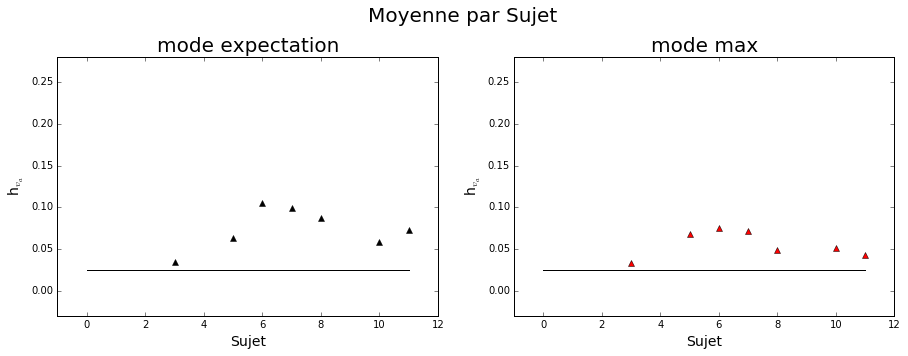

In [19]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par Sujet', fontsize=20, y=1.05)

axs[0].plot(range(len(h_va_m)), np.ones(len(h_va_m))*0.025, color='k', linewidth=1)
axs[1].plot(range(len(h_va_m)), np.ones(len(h_va_m))*0.025, color='k', linewidth=1)

for x in range(len(h_va_e)):
    #axs[0].errorbar(x, np.mean(h_va_e[x]), yerr=np.std(h_va_e[x]),color='k', fmt='o')
    #axs[1].errorbar(x, np.mean(h_va_m[x]), yerr=np.std(h_va_m[x]),color='r', fmt='o')
    axs[0].errorbar(x, np.average(h_va_e[x], weights=coco_va[x][0]),color='k', fmt='^')
    axs[1].errorbar(x, np.average(h_va_m[x], weights=coco_va[x][1]),color='r', fmt='^')
    
axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('Sujet', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-1, 12, -0.03, 0.28])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('Sujet', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-1, 12, -0.03, 0.28])

plt.show()

# figure Final !!!

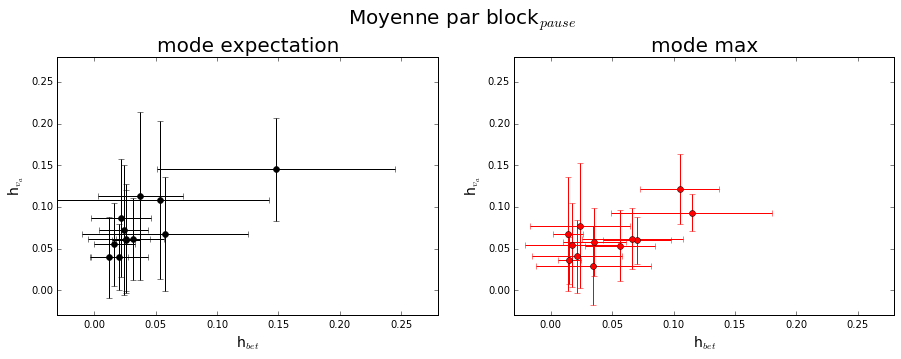

In [20]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par block$_{pause}$', fontsize=20, y=1.05)

for x in range(len(h_va_e[0])):
    axs[0].errorbar(np.mean(new_h_bet_e[x]), np.mean(new_h_va_e[x]), xerr=np.std(new_h_bet_e[x]), yerr=np.std(new_h_va_e[x]),color='k', fmt='o')
    axs[1].errorbar(np.mean(new_h_bet_m[x]), np.mean(new_h_va_m[x]), xerr=np.std(new_h_bet_m[x]), yerr=np.std(new_h_va_m[x]),color='r', fmt='o')

axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('h$_{bet}$', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-0.03 ,0.28,-0.03,0.28])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('h$_{bet}$', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-0.03 ,0.28,-0.03,0.28])

plt.show()

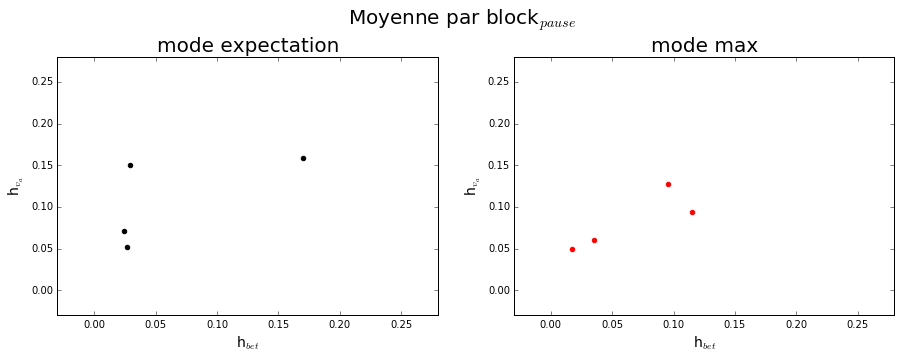

In [21]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par block$_{pause}$', fontsize=20, y=1.05)

for x in range(len(h_va_e[0])):
    axs[0].scatter(np.average(new_h_bet_e[x], weights=new_coco_bet_e[x]), np.average(new_h_va_e[x], weights=new_coco_va_e[x]),color='k')
    axs[1].scatter(np.average(new_h_bet_m[x], weights=new_coco_bet_m[x]), np.average(new_h_va_m[x], weights=new_coco_va_m[x]),color='r')
    
axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('h$_{bet}$', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-0.03 ,0.28,-0.03,0.28])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('h$_{bet}$', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-0.03 ,0.28,-0.03,0.28])

plt.show()

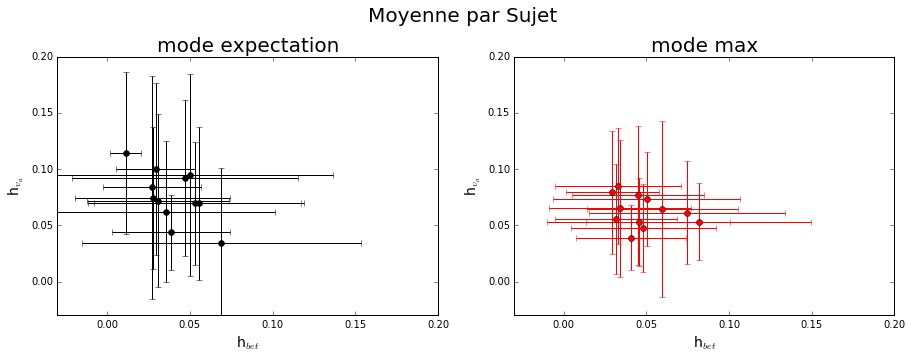

In [22]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par Sujet', fontsize=20, y=1.05)

for x in range(len(h_va_e)):
    axs[0].errorbar(np.mean(h_bet_e[x]), np.mean(h_va_e[x]), xerr=np.std(h_bet_e[x]), yerr=np.std(h_va_e[x]),color='k', fmt='o')
    axs[1].errorbar(np.mean(h_bet_m[x]), np.mean(h_va_m[x]), xerr=np.std(h_bet_m[x]), yerr=np.std(h_va_m[x]),color='r', fmt='o')

axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('h$_{bet}$', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-0.03 ,0.20,-0.03,0.20])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('h$_{bet}$', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-0.03 ,0.20,-0.03,0.20])

plt.show()

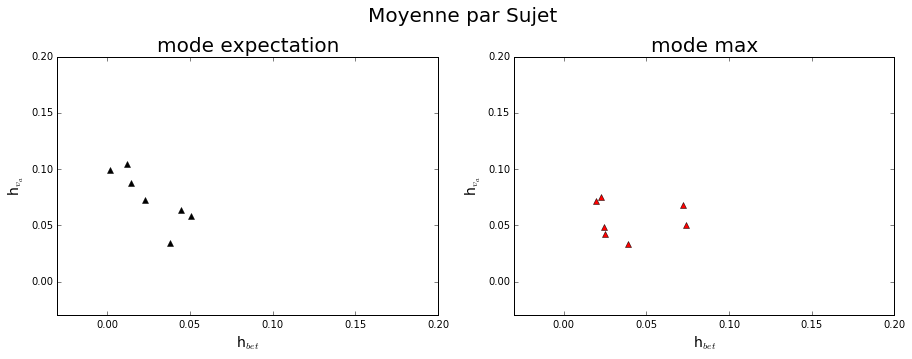

In [23]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par Sujet', fontsize=20, y=1.05)

for x in range(len(h_va_e)):
    
    axs[0].errorbar(np.average(h_bet_e[x], weights=coco_bet[x][0]), np.average(h_va_e[x], weights=coco_va[x][0]),color='k', fmt='^')
    axs[1].errorbar(np.average(h_bet_m[x], weights=coco_bet[x][1]), np.average(h_va_m[x], weights=coco_va[x][1]),color='r', fmt='^')

axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('h$_{bet}$', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-0.03 ,0.20,-0.03,0.20])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('h$_{bet}$', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-0.03 ,0.20,-0.03,0.20])

plt.show()

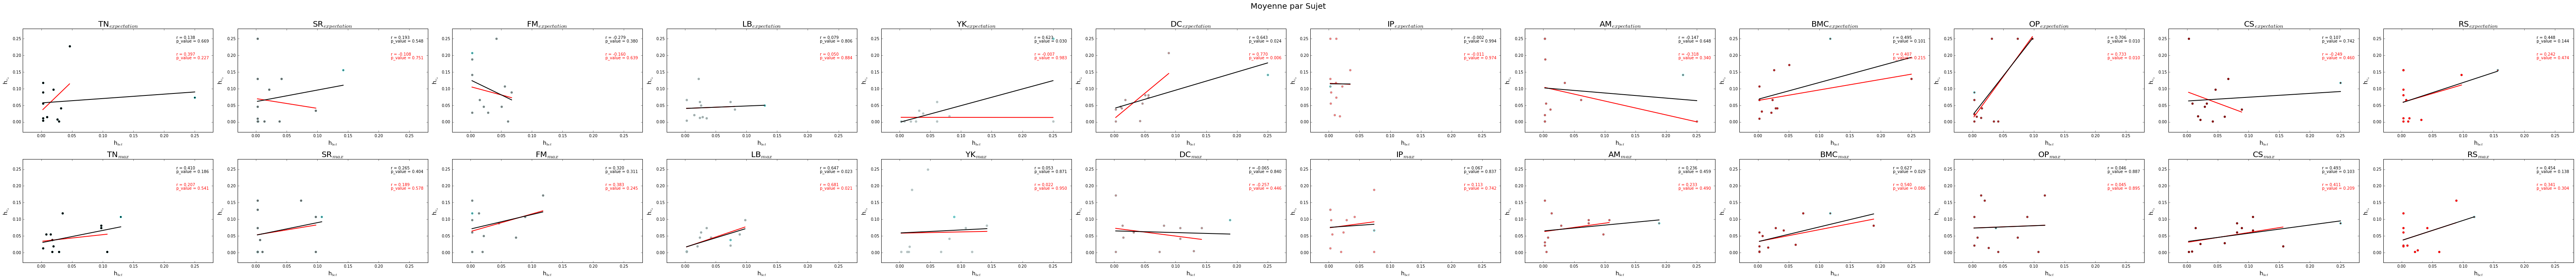

In [24]:
fig, axs = plt.subplots(2, len(exp), figsize=((fig_width*(len(exp)/2)), (fig_width)/(1.6180)))

plt.suptitle('Moyenne par Sujet', fontsize=20, y=1.05)


for x, color in enumerate(['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']):
    for a in range(len(h_va_e)):
        axs[0][x].scatter(h_bet_e[x][a], h_va_e[x][a],color=color, edgecolors='c')
        axs[1][x].scatter(h_bet_m[x][a], h_va_m[x][a],color=color, edgecolors='c')
        if a != 0 :
            axs[0][x].scatter(h_bet_e[x][a], h_va_e[x][a],color=color, edgecolors=color)
            axs[1][x].scatter(h_bet_m[x][a], h_va_m[x][a],color=color, edgecolors=color)
    #------------------------------------------------------------------------
    slope, intercept, r_value, p_value, std_err = stats.linregress(h_bet_e[x][1:], h_va_e[x][1:])
    x_test = np.linspace(np.min(h_bet_e[x][1:]), np.max(h_bet_e[x][1:]), 100)
    fitLine = slope * x_test + intercept
    axs[0][x].plot(x_test, fitLine, c='r', linewidth=2)
    axs[0][x].text(0.22,0.20, 'r = %0.3f'%(r_value), color='r', fontsize=10)
    axs[0][x].text(0.22,0.19, 'p_value = %0.3f'%(p_value), color='r', fontsize=10)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(h_bet_m[x][1:], h_va_m[x][1:])
    x_test = np.linspace(np.min(h_bet_m[x][1:]), np.max(h_bet_m[x][1:]), 100)
    fitLine = slope * x_test + intercept
    axs[1][x].plot(x_test, fitLine, c='r', linewidth=2)
    axs[1][x].text(0.22,0.20, 'r = %0.3f'%(r_value), color='r', fontsize=10)
    axs[1][x].text(0.22,0.19, 'p_value = %0.3f'%(p_value), color='r', fontsize=10)
    
    #------------------------------------------------------------------------
    slope, intercept, r_value, p_value, std_err = stats.linregress(h_bet_e[x], h_va_e[x])
    x_test = np.linspace(np.min(h_bet_e[x]), np.max(h_bet_e[x]), 100)
    fitLine = slope * x_test + intercept
    axs[0][x].plot(x_test, fitLine, c='k', linewidth=2)
    axs[0][x].text(0.22,0.25, 'r = %0.3f'%(r_value), color='k', fontsize=10)
    axs[0][x].text(0.22,0.24, 'p_value = %0.3f'%(p_value), color='k', fontsize=10)
    
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(h_bet_m[x], h_va_m[x])
    x_test = np.linspace(np.min(h_bet_m[x]), np.max(h_bet_m[x]), 100)
    fitLine = slope * x_test + intercept
    axs[1][x].plot(x_test, fitLine, c='k', linewidth=2)
    axs[1][x].text(0.22,0.25, 'r = %0.3f'%(r_value), color='k', fontsize=10)    
    axs[1][x].text(0.22,0.24, 'p_value = %0.3f'%(p_value), color='k', fontsize=10)
    #------------------------------------------------------------------------
    
    axs[0][x].set_title('%s$_{expectation}$'%(exp[x]['observer']), fontsize=20)
    axs[0][x].set_xlabel('h$_{bet}$', fontsize=14)
    axs[0][x].set_ylabel('h$_{v_a}$', fontsize=14)
    axs[0][x].axis([-0.03 ,0.28,-0.03,0.28])

    axs[1][x].set_title('%s$_{max}$'%(exp[x]['observer']), fontsize=20)
    axs[1][x].set_xlabel('h$_{bet}$', fontsize=14)
    axs[1][x].set_ylabel('h$_{v_a}$', fontsize=14)
    axs[1][x].axis([-0.03 ,0.28,-0.03,0.28])
    fig.tight_layout()
plt.show()

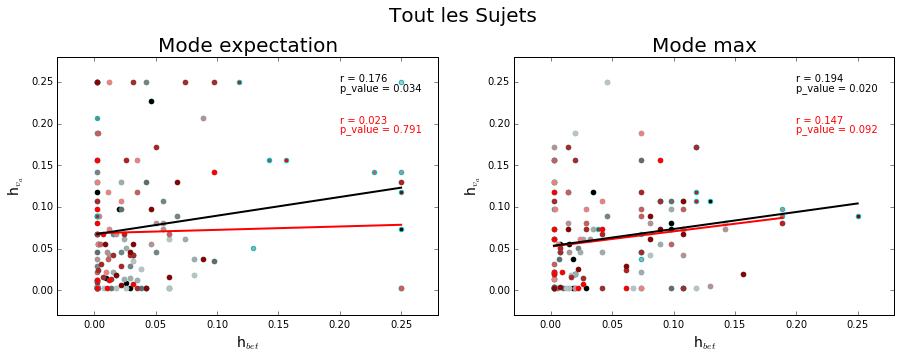

In [25]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))

plt.suptitle('Tout les Sujets', fontsize=20, y=1.05)

bet_e = []
bet_m = []
va_e = []
va_m = []
bet_e_0 = []
bet_m_0 = []
va_e_0 = []
va_m_0 = []

for x, color in enumerate(['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']):
    for a in range(len(h_va_e)):
        axs[0].scatter(h_bet_e[x][a], h_va_e[x][a],color=color, edgecolors='c')
        axs[1].scatter(h_bet_m[x][a], h_va_m[x][a],color=color, edgecolors='c')
        if a != 0 :
            axs[0].scatter(h_bet_e[x][a], h_va_e[x][a],color=color, edgecolors=color)
            axs[1].scatter(h_bet_m[x][a], h_va_m[x][a],color=color, edgecolors=color)
            bet_e_0.append(h_bet_e[x][a])
            bet_m_0.append(h_bet_m[x][a])
            va_e_0.append(h_va_e[x][a])
            va_m_0.append(h_va_m[x][a])
        bet_e.append(h_bet_e[x][a])
        bet_m.append(h_bet_m[x][a])
        va_e.append(h_va_e[x][a])
        va_m.append(h_va_m[x][a])

#------------------------------------------------------------------------
slope, intercept, r_value, p_value, std_err = stats.linregress(bet_e_0, va_e_0)
x_test = np.linspace(np.min(bet_e_0), np.max(bet_e_0), 100)
fitLine = slope * x_test + intercept
axs[0].plot(x_test, fitLine, c='r', linewidth=2)
axs[0].text(0.20,0.20, 'r = %0.3f'%(r_value), color='r', fontsize=10)
axs[0].text(0.20,0.19, 'p_value = %0.3f'%(p_value), color='r', fontsize=10)

slope, intercept, r_value, p_value, std_err = stats.linregress(bet_m_0, va_m_0)
x_test = np.linspace(np.min(bet_m_0), np.max(bet_m_0), 100)
fitLine = slope * x_test + intercept
axs[1].plot(x_test, fitLine, c='r', linewidth=2)
axs[1].text(0.20,0.20, 'r = %0.3f'%(r_value), color='r', fontsize=10)    
axs[1].text(0.20,0.19, 'p_value = %0.3f'%(p_value), color='r', fontsize=10)

#------------------------------------------------------------------------
slope, intercept, r_value, p_value, std_err = stats.linregress(bet_e, va_e)
x_test = np.linspace(np.min(bet_e), np.max(bet_e), 100)
fitLine = slope * x_test + intercept
axs[0].plot(x_test, fitLine, c='k', linewidth=2)
axs[0].text(0.20,0.25, 'r = %0.3f'%(r_value), color='k', fontsize=10)
axs[0].text(0.20,0.24, 'p_value = %0.3f'%(p_value), color='k', fontsize=10)

slope, intercept, r_value, p_value, std_err = stats.linregress(bet_m, va_m)
x_test = np.linspace(np.min(bet_m), np.max(bet_m), 100)
fitLine = slope * x_test + intercept
axs[1].plot(x_test, fitLine, c='k', linewidth=2)
axs[1].text(0.20,0.25, 'r = %0.3f'%(r_value), color='k', fontsize=10)    
axs[1].text(0.20,0.24, 'p_value = %0.3f'%(p_value), color='k', fontsize=10)

#------------------------------------------------------------------------

axs[0].set_title('Mode expectation', fontsize=20)
axs[0].set_xlabel('h$_{bet}$', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-0.03 ,0.28,-0.03,0.28])

axs[1].set_title('Mode max', fontsize=20)
axs[1].set_xlabel('h$_{bet}$', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-0.03 ,0.28,-0.03,0.28])

plt.show()

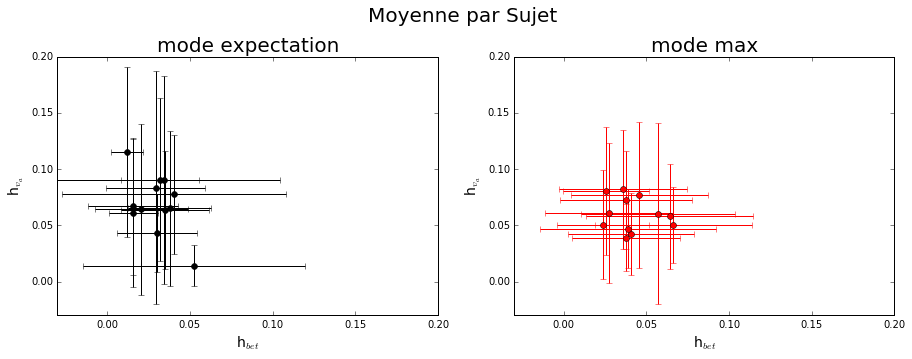

In [26]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
plt.suptitle('Moyenne par Sujet', fontsize=20, y=1.05)

for x in range(len(h_va_e)):
    axs[0].errorbar(np.mean(h_bet_e[x][1:]), np.mean(h_va_e[x][1:]), xerr=np.std(h_bet_e[x][1:]), yerr=np.std(h_va_e[x][1:]),color='k', fmt='o')
    axs[1].errorbar(np.mean(h_bet_m[x][1:]), np.mean(h_va_m[x][1:]), xerr=np.std(h_bet_m[x][1:]), yerr=np.std(h_va_m[x][1:]),color='r', fmt='o')

axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('h$_{bet}$', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-0.03 ,0.20,-0.03,0.20])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('h$_{bet}$', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-0.03 ,0.20,-0.03,0.20])

plt.show()

###  Figure des différents h